# Exploratory Data Analysis: Powerlifting Sport
Ref: [Powerlifting Strength Analysis](https://www.rpubs.com/sthalder/powerlifting_analysis)

The main objective of this analysis is to identify major factors which influences an individual’s ability to do Powerlifting. As a sport, an individual gets 3 attempts on three lifts: squat, bench press and deadlift ([Wikipedia](https://en.wikipedia.org/wiki/Powerlifting) has many details around the sport itself, as well as more details around the three lifts; [Here](https://strengthlevel.com/strength-standards/bench-press) has some sketches of the three lifts, you could select more exercises in the end of the page). There are many championships which take place around the world all along the year. All these competitions may have different age, weight and equipment categories; but the burning question every person debate, either as an audience or a powerlifter is how much weight will be lifted successfully by every player? By the end of this analysis, fans of the sport will have some inkling about their favorite player’s ability. Also, the players themselves can understand their strengths and weaknesses; and plan to perform better in future competitions.

As a powerlifter trains throughout their career, there are many factors which keep varying both internally and externally. We will perform separate analysis for male and female. This week's data is from Open Powerlifting. The data available of players has age groups starting from early teens to late 70s. Along with it, we have corresponding bodyweights for players in those competitions. We also have the maximum lift data by players in their respective division, i.e. best squat, bench press and deadlift.

Data can be found in Canvas or [OpenPowerlifting Data Service](https://openpowerlifting.gitlab.io/opl-csv/bulk-csv.html).

### Load Data
For analysis, most of the packages used will be base R for data cleaning, manipulation and analyzing. There are some other packages which will be used like readr, dplyr, ggplot2. Users must install (`install.packages(“package_name”)`) and load these packages prior to the analysis.

Below is how to load above mentioned packages along with their short description:

In [2]:
library(readr)        # Reading CSV file
library(dplyr)        # Majorly used for data cleaning and manipulation 
library(ggplot2)      # For creating better visualization
library(ggcorrplot)   # Visualize a correlation matrix
library(gridExtra)    # Plot ggplot side-by-side
library(lubridate)    # Extract date parts from date column

We import the data into R and perform some initial checks. The dimension of dataset is 41,152 observations with 16 variables. While checking for the structure, it is found that all variables have been assigned the appropriate data type and hence no modification is needed. At an overall level, there are no signs of any duplicates. The main variables of interest for the analysis here are:
- equipment
- age
- bodyweight
- best3squat
- best3bench
- best3deadlift
- date

In [3]:
# Importing CSV file
pl_data <- read_csv("ipf_lifts.csv")

Rows: 41152 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): name, sex, event, equipment, age_class, division, weight_class_kg...
dbl   (5): age, bodyweight_kg, best3squat_kg, best3bench_kg, best3deadlift_kg
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


For simplicity, we drop observation that contains missing values.

In [4]:
pl_data = pl_data %>% na.omit

Since all the weight columns are in kg, it will be better to remove the suffix `_kg`.

In [5]:
pl_data <- rename(pl_data, 
                  bodyweight = bodyweight_kg, 
                  weight_class = weight_class_kg,
                  best3squat = best3squat_kg,
                  best3bench = best3bench_kg,
                  best3deadlift = best3deadlift_kg)

A record of the three lifts is impossible to be negative. Hence, we exclude them in our analysis.

In [6]:
# There are negative values which needs to be filtered
pl_data <- filter(pl_data, best3deadlift > 0 & best3bench > 0 & best3squat > 0)

In [7]:
# Removing columns that won't be needed in our analysis
pl_mds <- select(pl_data, -c(division, place, meet_name, federation))

# Reordering the columns
pl_mds <- pl_mds[, c(1,2,3,12,4,5,6,7,8,9,10,11)]

A primitive investigation of the dataset:

In [8]:
str(pl_mds)

tibble [23,812 × 12] (S3: tbl_df/tbl/data.frame)
 $ name         : chr [1:23812] "Anna-Liisa Prinkkala" "Vuokko Viitasaari" "Maria DelCastillo" "Helen Wolsey" ...
 $ sex          : chr [1:23812] "F" "F" "F" "F" ...
 $ event        : chr [1:23812] "SBD" "SBD" "SBD" "SBD" ...
 $ date         : Date[1:23812], format: "1989-11-13" "1989-11-13" ...
 $ equipment    : chr [1:23812] "Single-ply" "Single-ply" "Single-ply" "Single-ply" ...
 $ age          : num [1:23812] 33.5 34.5 23.5 27.5 37.5 25.5 33.5 26 33.5 32.5 ...
 $ age_class    : chr [1:23812] "24-34" "24-34" "24-34" "24-34" ...
 $ bodyweight   : num [1:23812] 44 44 44 44 44 44 48 48 48 48 ...
 $ weight_class : chr [1:23812] "44" "44" "44" "44" ...
 $ best3squat   : num [1:23812] 135 120 130 112 105 ...
 $ best3bench   : num [1:23812] 60 62.5 62.5 60 65 45 62.5 77.5 65 62.5 ...
 $ best3deadlift: num [1:23812] 145 145 120 135 130 ...
 - attr(*, "na.action")= 'omit' Named int [1:17337] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr

## EDA

### Gender and Bodyweight

Due to the biological difference, gender is an essential factor in sports. A common approach is to consider each gender as a stratification of the whole dataset. We will adapt the approch in our later analysis.

In [9]:
eda1 = pl_mds %>% group_by(sex) %>% count() %>% 
  ungroup() %>% 
  mutate(perc = `n` / sum(`n`)) %>% 
  arrange(perc) %>%
  mutate(labels = scales::percent(perc))

eda1 

sex,n,perc,labels
<chr>,<int>,<dbl>,<chr>
F,8393,0.3524693,35%
M,15419,0.6475307,65%


The number of male atheletes is about twice of that of female atheletes. 

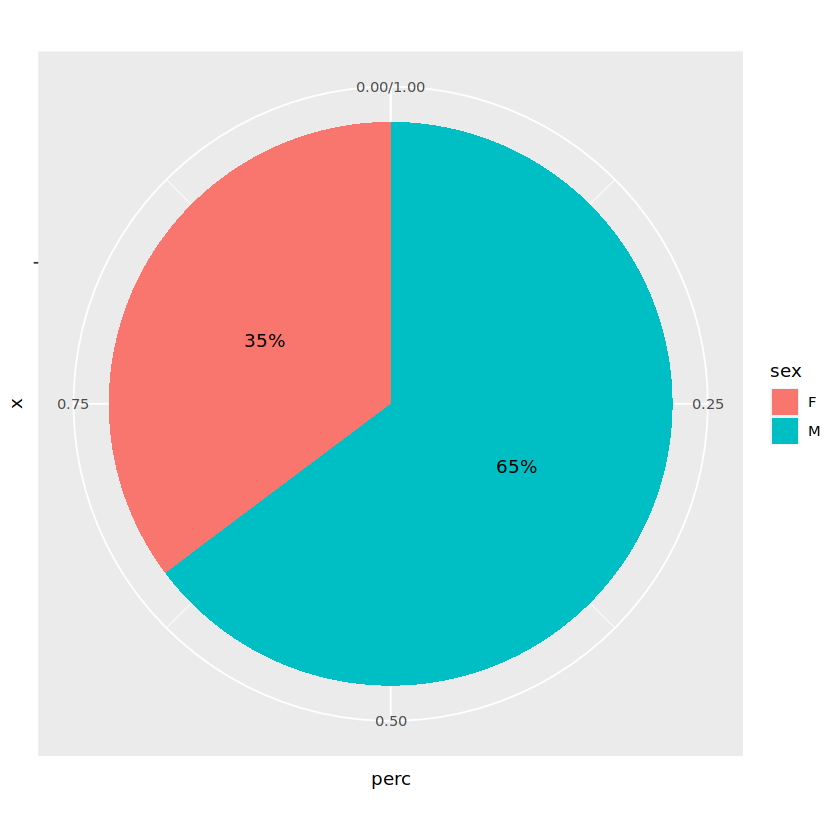

In [10]:
ggplot(eda1, aes(x = "", y = perc, fill = sex)) + 
    geom_col() + 
    geom_text(aes(label = labels), position = position_stack(vjust = 0.5)) + 
    coord_polar(theta = "y")

Bodyweight also plays an important factor of strength. We analyzie the bodyweight for both male and female.

In [11]:
# Creating subsets of final data by gender
pl_mds_m <- filter(pl_mds, sex == "M")
pl_mds_f <- filter(pl_mds, sex == "F")

In [12]:
summary(pl_mds_m$bodyweight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.35   71.14   82.61   87.93  102.90  214.00 

In [13]:
summary(pl_mds_f$bodyweight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  37.29   51.80   60.89   64.99   72.85  162.40 

According to the summary statistics, we already find that male tend to have heavier bodyweights than female. We can visualize it using `ggplot`.

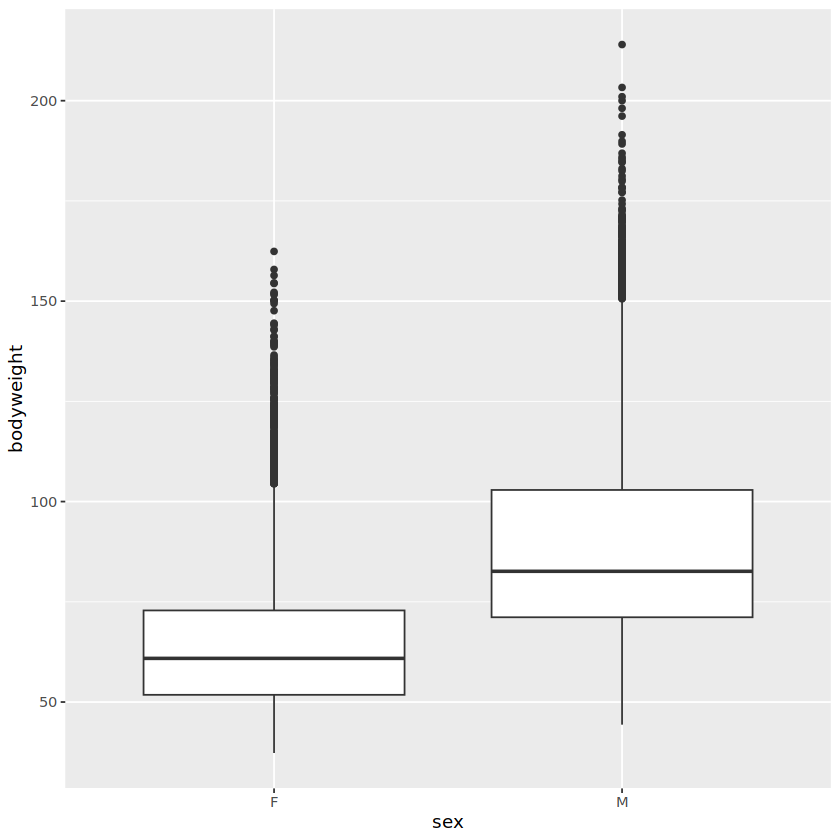

In [14]:
pl_mds %>% ggplot() +
    geom_boxplot(aes(x = sex, y = bodyweight, group = sex))

### Lifts, Bodyweight, and Equipment Type

There is a very noticeable relation between bodyweight and the lifting ability of individuals. It shows as bodyweight increases, the strength and lifting ability increases. This can be seen in the correlation matrix and below charts for all 3 lifts. We demonstrate that there is a strong positive correlation between bodyweight and the three lifts. 

We also find that bench press and deadlift are relatively has less correlation than the other lifts. It is posible due to the advantage of athelete's anatomy. It is known that athelte who has longer arms has more range of motion in banch press, but less range of motion in deadlift. Thus, the athelte may be eaisr to lift in deadlift, but harder to lift in banch press.

In [15]:
corr = pl_mds %>% select(c(bodyweight, best3squat, best3bench, best3deadlift)) %>% cor
corr

,bodyweight,best3squat,best3bench,best3deadlift
bodyweight,1.0000000,0.7087839,0.7126625,0.6751887
best3squat,0.7087839,1.0000000,0.9191624,0.9168452
best3bench,0.7126625,0.9191624,1.0000000,0.8584600
best3deadlift,0.6751887,0.9168452,0.8584600,1.0000000


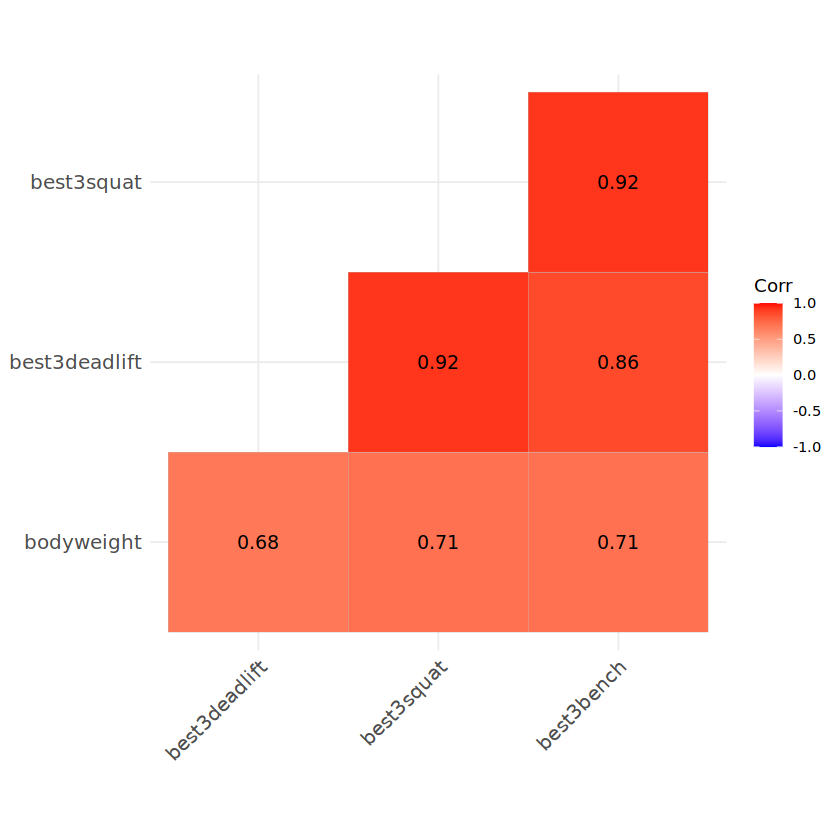

In [16]:
ggcorrplot(corr, type = "lower", hc.order = TRUE, lab = TRUE)

There are 3 equipment types and major observations are present for raw and single-ply. We show that the positive correlation also preserves within the gender and equipment type.

In [ ]:
p1 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = bodyweight, y = best3squat, color = "Male")) + 
 geom_smooth(data = pl_mds_m, aes(x = bodyweight, y = best3squat), 
             colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = bodyweight, y = best3squat, color = "Female")) + 
geom_smooth(data = pl_mds_f, aes(x = bodyweight, y = best3squat), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Bodyweight") +
  ylab("Squat lifts in kg") +
  ggtitle("Effect of bodyweight on squat weights")

p2 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = bodyweight, y = best3bench, color = "Male")) + 
geom_smooth(data = pl_mds_m, aes(x = bodyweight, y = best3bench), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = bodyweight, y = best3bench, color = "Female")) +
geom_smooth(data = pl_mds_f, aes(x = bodyweight, y = best3bench), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Bodyweight") +
  ylab("Benchpress lifts in kg") +
  ggtitle("Effect of bodyweight on bench press weights")

p3 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = bodyweight, y = best3deadlift, color = "Male")) +
geom_smooth(data = pl_mds_m, aes(x = bodyweight, y = best3deadlift), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = bodyweight, y = best3deadlift, color = "Female")) + 
geom_smooth(data = pl_mds_f, aes(x = bodyweight, y = best3deadlift), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Bodyweight") +
  ylab("Deadlift weight in kg") +
  ggtitle("Effect of bodyweight on deadlift weights")

# Divide frame in grid using grid.arrange function 
# and put above created plot int it
grid.arrange(p1, p2, p3, nrow = 3)

It’s crystal clear that bodyweight holds a positive relation with strength for both male and female and all equipments type. It seems like the bigger you are, the more you will lift.
 
Furthermore, we find that equipment type plays a significant influence of the lifts. According to the slope of the trend, single-ply is a huge boost to both genders especially for squat and bench press. This boost is comparatively very less for deadlift.

### Time, Gender, and Bodyweight

Let’s try to find if the average weightlifting ability has changed over the period. This is done by plotting the correlation matrix and the trend of average weight lifted in every year. 

In [ ]:
# Adding a variable which extracts year from date
pl_mds_m <- mutate(pl_mds_m, year = year(date))

corr = pl_mds_m %>% select(c(year, best3squat, best3bench, best3deadlift)) %>% cor
corr

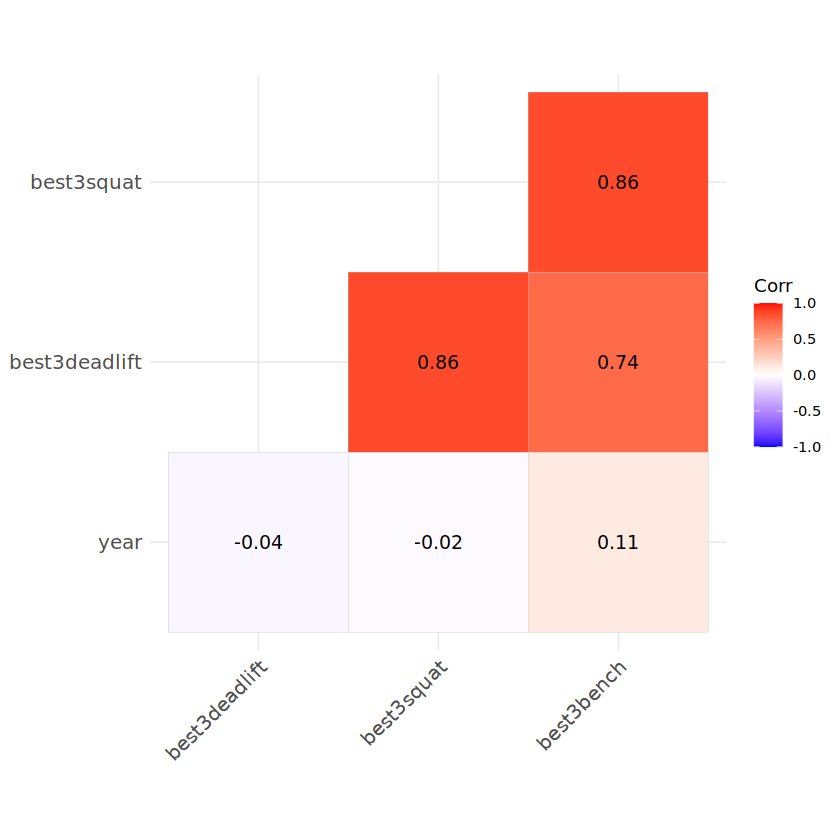

In [47]:
ggcorrplot(corr, type = "lower", hc.order = TRUE, lab = TRUE)

According to the correlation matrix, we find that the association between year and strength is little, but it seems like year and bench press has a weak positive correlation.

We funther investigate the strength change in year within different gender.

In [44]:
# Creating a dataframe which contains average lifts by year
year_avg_m <- 
  pl_mds_m %>% 
  group_by(year) %>% 
  summarize(avg_bs = mean(best3squat, na.rm = T),
            avg_bb = mean(best3bench, na.rm = T),
            avg_bd = mean(best3deadlift, na.rm = T))

# Adding a variable which extracts year from date
pl_mds_f <- mutate(pl_mds_f, year = year(date))

# Creating a dataframe which contains average lifts by year
year_avg_f <- 
  pl_mds_f %>% 
  group_by(year) %>% 
  summarize(avg_bs = mean(best3squat, na.rm = T),
            avg_bb = mean(best3bench, na.rm = T),
            avg_bd = mean(best3deadlift, na.rm = T))

For male and female, it seems that there is some progress in bench press ability, especially since 1990. However, there isn’t much of a change in the other 2 lifts. Overall it has remained roughly constant throughout the years. At this stage, it looks like males may have grown stronger over the years, but it cannot be said with utmost confidence yet. Further investigation is needed. The total weight lifted for squats and deadlift is very high than bench press, since more leg muscles are used in them. Besides, male atheltes tend to lift heavier than female atheltes.

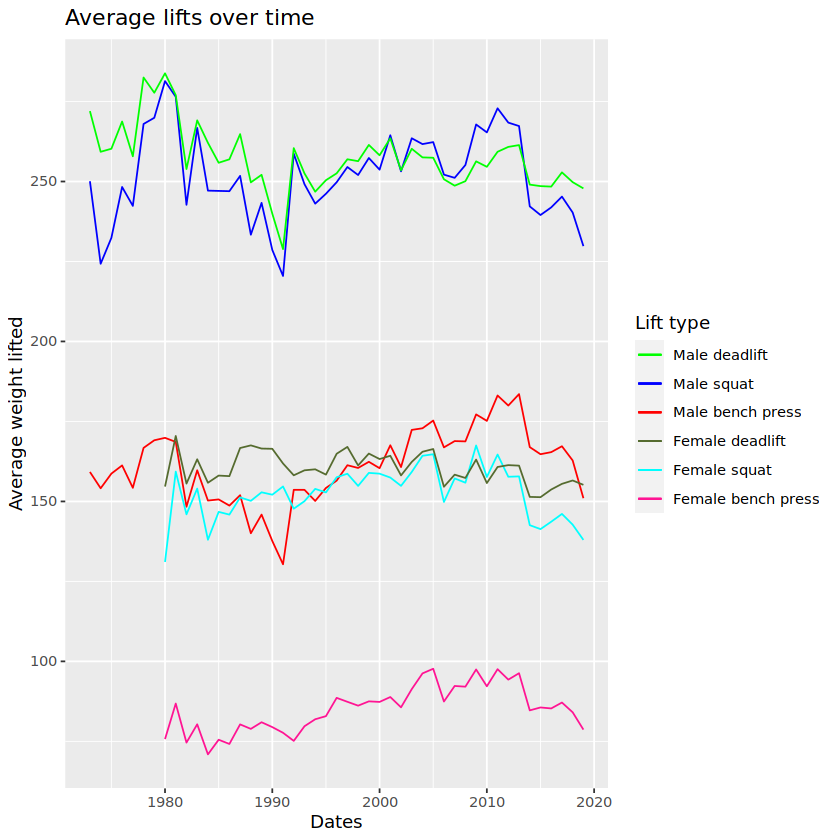

In [111]:
# Plotting the trend of 3 lifts on a yearly basis
ggplot() +

  geom_line(data = year_avg_m, aes(x = year, y = avg_bs, color = "Male squat")) +
  geom_line(data = year_avg_m, aes(x = year, y = avg_bb, color = "Male bench press")) +
  geom_line(data = year_avg_m, aes(x = year, y = avg_bd, color = "Male deadlift")) +

  geom_line(data = year_avg_f, aes(x = year, y = avg_bs, color = "Female squat")) +
  geom_line(data = year_avg_f, aes(x = year, y = avg_bb, color = "Female bench press")) +
  geom_line(data = year_avg_f, aes(x = year, y = avg_bd, color = "Female deadlift")) +
  xlab("Dates") +
  ylab("Average weight lifted") +
  scale_colour_manual(name = "Lift type", 
                      breaks = c("Male deadlift", "Male squat", "Male bench press",
                                 "Female deadlift", "Female squat", "Female bench press"),
                    values = c("green", "blue", "red", "darkolivegreen", "cyan", "deeppink")) +
  ggtitle("Average lifts over time")

Hoever, the previous analysis does not consider the bodyweight change in years. According the previous analysis of bodyweight. It is likely that the increase of strength is due to the increase of bodyweight. One practical solution to address the concern is to consider the lifting weight with respect to lifters' bodyweight. That is,
$$\text{How much self weight you can lift} = \frac{\text{How much you lift}}{\text{How much you weight}} $$

In [187]:
# Adding a variable which extracts year from date
pl_mds_m <- mutate(pl_mds_m, 
                   squat_ratio = best3squat/bodyweight,
                   bench_ratio = best3bench/bodyweight,
                   deadlift_ratio = best3deadlift/bodyweight)

pl_mds_f <- mutate(pl_mds_f, 
                   squat_ratio = best3squat/bodyweight,
                   bench_ratio = best3bench/bodyweight,
                   deadlift_ratio = best3deadlift/bodyweight)

In [189]:
# Creating a dataframe which contains average lifts by year
ratio_m <- 
  pl_mds_m %>% 
  group_by(year) %>% 
  summarize(avg_bs = mean(squat_ratio, na.rm = T),
            avg_bb = mean(bench_ratio, na.rm = T),
            avg_bd = mean(deadlift_ratio, na.rm = T))

# Creating a dataframe which contains average lifts by year
ratio_f <- 
  pl_mds_f %>% 
  group_by(year) %>% 
  summarize(avg_bs = mean(squat_ratio, na.rm = T),
            avg_bb = mean(bench_ratio, na.rm = T),
            avg_bd = mean(deadlift_ratio, na.rm = T))

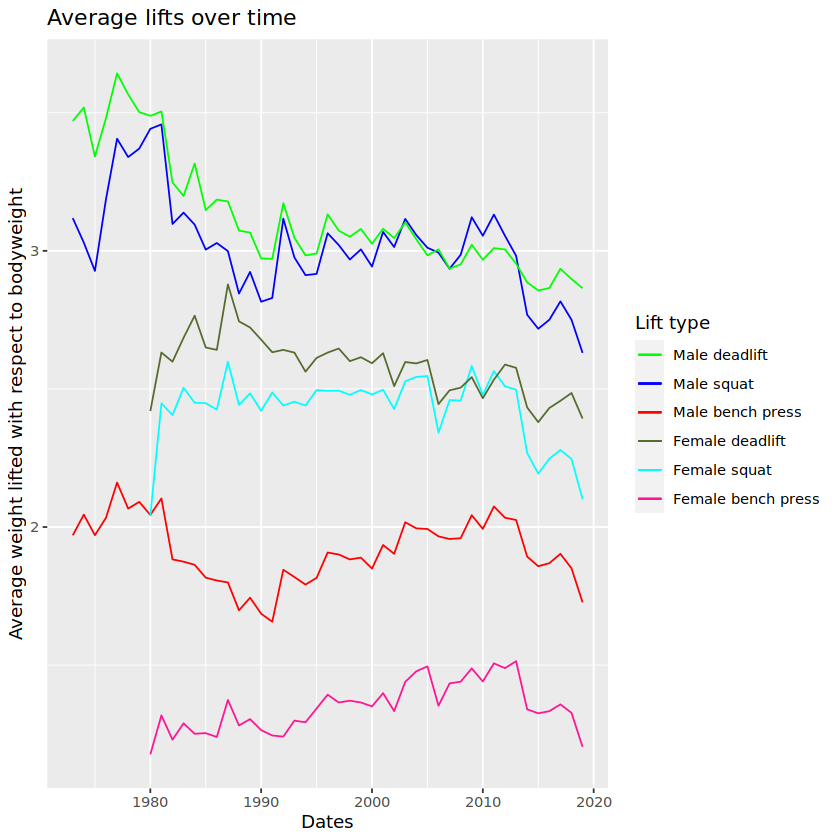

In [190]:
ggplot() +

  geom_line(data = ratio_m, aes(x = year, y = avg_bs, color = "Male squat")) +
  geom_line(data = ratio_m, aes(x = year, y = avg_bb, color = "Male bench press")) +
  geom_line(data = ratio_m, aes(x = year, y = avg_bd, color = "Male deadlift")) +

  geom_line(data = ratio_f, aes(x = year, y = avg_bs, color = "Female squat")) +
  geom_line(data = ratio_f, aes(x = year, y = avg_bb, color = "Female bench press")) +
  geom_line(data = ratio_f, aes(x = year, y = avg_bd, color = "Female deadlift")) +
  xlab("Dates") +
  ylab("Average weight lifted with respect to bodyweight") +
  scale_colour_manual(name = "Lift type", 
                      breaks = c("Male deadlift", "Male squat", "Male bench press",
                                 "Female deadlift", "Female squat", "Female bench press"),
                    values = c("green", "blue", "red", "darkolivegreen", "cyan", "deeppink")) +
  ggtitle("Average lifts over time")

With the consideration of bodyweight, we find bench press in female still alligns to the previous investigation, but bench press in male seens to be constant, and the other two lifts seem to decrease over time.

Furthermore, we find male atheltes tend to lift heavir than female atheltes even when bodyweight is considered.

### Age and Equipment Type

We’ll try to see how age affects an individual’s lifting ability for all 3 lifts.

In [48]:
corr = pl_mds_m %>% select(c(age, best3squat, best3bench, best3deadlift)) %>% cor
corr

,age,best3squat,best3bench,best3deadlift
age,1.0000000,-0.2847984,-0.2030239,-0.2340712
best3squat,-0.2847984,1.0000000,0.8631301,0.8556707
best3bench,-0.2030239,0.8631301,1.0000000,0.7385070
best3deadlift,-0.2340712,0.8556707,0.7385070,1.0000000


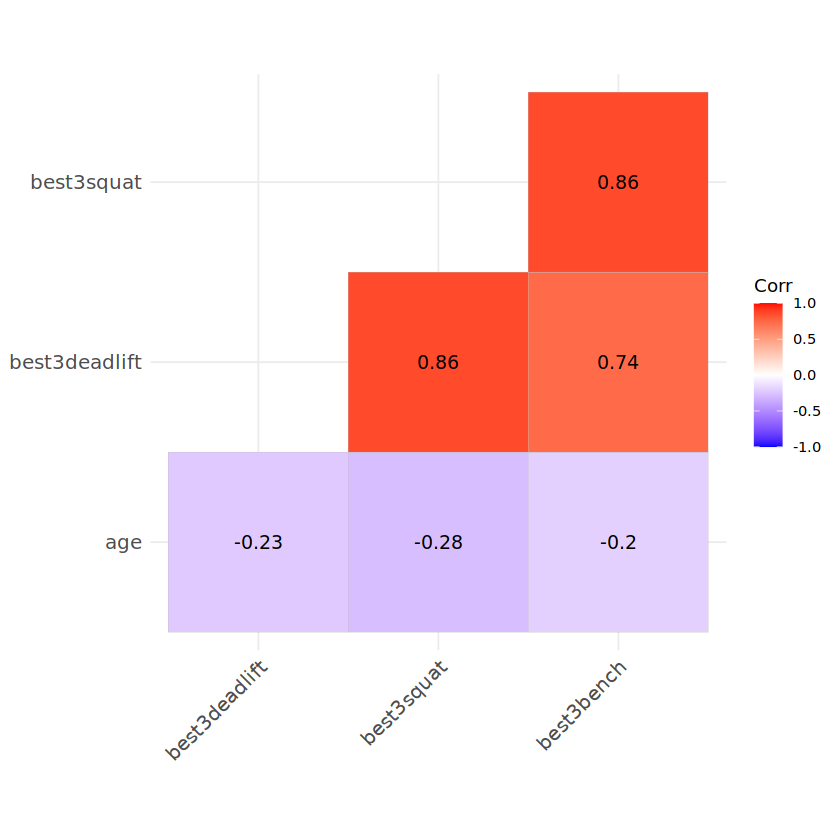

In [49]:
ggcorrplot(corr, type = "lower", hc.order = TRUE, lab = TRUE)

According to the correlation matrix, there is a negative association between age and strength.

We funther investigate the strength change in age within different gender and equipment type.

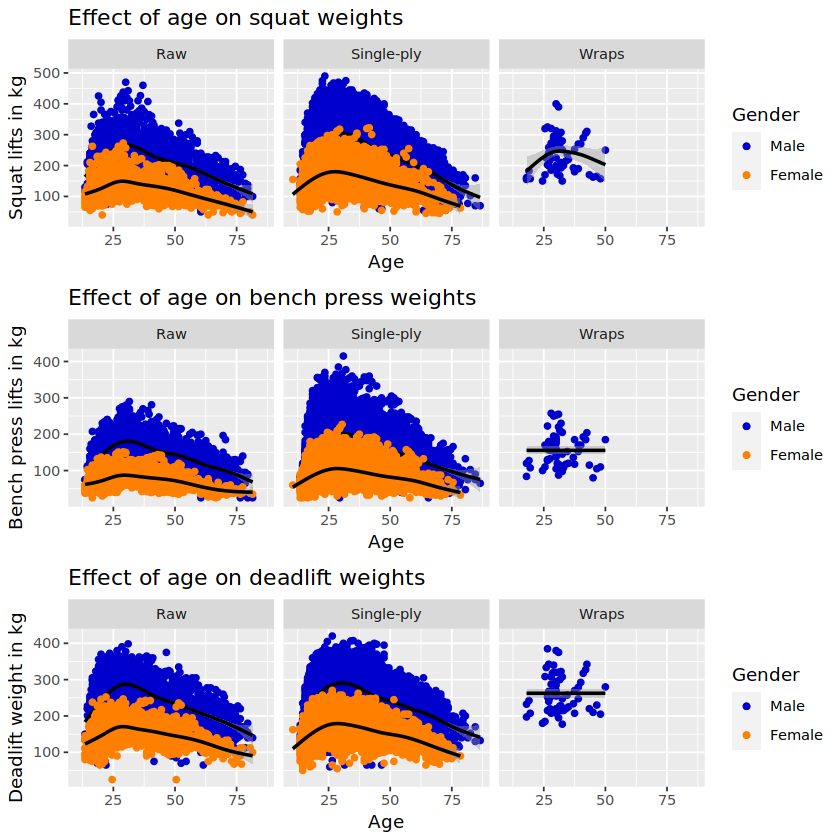

In [41]:
p4 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = age, y = best3squat, color = "Male")) + 
geom_smooth(data = pl_mds_m, aes(x = age, y = best3squat), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = age, y = best3squat, color = "Female")) + 
geom_smooth(data = pl_mds_f, aes(x = age, y = best3squat), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Age") +
  ylab("Squat lifts in kg") +
  ggtitle("Effect of age on squat weights")

p5 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = age, y = best3bench, color = "Male")) + 
geom_smooth(data = pl_mds_m, aes(x = age, y = best3bench), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = age, y = best3bench, color = "Female")) + 
geom_smooth(data = pl_mds_f, aes(x = age, y = best3bench), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Age") +
  ylab("Bench press lifts in kg") +
  ggtitle("Effect of age on bench press weights")

p6 = ggplot() + 

 geom_point(data = pl_mds_m, aes(x = age, y = best3deadlift, color = "Male")) + 
geom_smooth(data = pl_mds_m, aes(x = age, y = best3deadlift), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +
  geom_point(data = pl_mds_f, aes(x = age, y = best3deadlift, color = "Female")) + 
geom_smooth(data = pl_mds_f, aes(x = age, y = best3deadlift), 
            colour = "black", method = 'gam', formula = y ~ s(x, bs = "cs")) +
  facet_wrap(~ equipment, nrow = 1) +

 scale_colour_manual(name = "Gender", 
                      breaks = c("Male", "Female"),
                    values = c("blue3", "darkorange1"))+
  xlab("Age") +
  ylab("Deadlift weight in kg") +
  ggtitle("Effect of age on deadlift weights")

# Divide frame in grid using grid.arrange function 
# and put above created plot int it
grid.arrange(p4, p5, p6, nrow = 3)

It seems that both men and women reach their peak strength around the age of 25. Post that, it seems to follow a downward trend. One interpretation is that as you get older, it’s more difficult to lift heavy weights Besides, once the strength starts to decrease, the strength of men decreases at a faster rate of female. 

Finally, we already see that the equipment type used is a major factor in an individual’s lifting ability. It’s not a heavy influencer for deadlift but provides high boost in squat and bench press.

## Conclusion

We summarize the findings from our EDA.

- Gender
    - Male athelte tend to have heavir bodyweight than female (roughly two times heavir)
    - Male atheltes tend to lift heavir than female atheltes even when bodyweight is considered. 
- Lifts
    - All three lifts have a strong correlation to each other. However, deadlift and bench press are less correlated than other lifts. One possible reason is athelets' anatomy. 
- Bodyweight
    - Bodyweight are highly correlated to the strength: the bigger you are, the more you will lift.
- Equipment type
    - Single-ply equipment provides a huge boost to both genders especially for squat and bench press. This boost is comparatively very less for deadlift 
- Age
    - Weak negative correlated to the strength
    - Atheletes reach their peak strength around the age of 25
    - The downward trend of year in strength for women seems to occur at a slower rate then men
- Time 
    - little correlated to the strength, but weak positive correlated with bench press
    - Atheltes have shown a little increase in the average bench press weight lifted, while there’s not much of a change in squat and deadlift, and even decrease in the average if bodyweight is considered. However, further investigation is needed to determine the effect of years.